<a href="https://colab.research.google.com/github/BearKS/Robotic-weed-control-system/blob/feature%2Fsegmentation/Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.9.0
!pip install albumentations>=0.3.0 
!pip install --pre segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/Project/predataset2.zip

Archive:  /content/drive/MyDrive/Project/predataset2.zip
   creating: predataset/test/
   creating: predataset/test/images/
  inflating: predataset/test/images/T02_Box007_2017-09-09T08-52-40-045.png  
  inflating: predataset/test/images/T02_Box007_2017-09-10T05-55-35-248.png  
  inflating: predataset/test/images/T02_Box007_2017-09-11T10-38-11-116.png  
  inflating: predataset/test/images/T02_Box007_2017-09-28T10-42-55-040.png  
  inflating: predataset/test/images/T02_Box007_2017-09-29T11-27-55-959.png  
  inflating: predataset/test/images/T02_Box007_2017-10-04T10-15-38-256.png  
  inflating: predataset/test/images/T02_Box007_2017-10-06T13-40-15-271.png  
  inflating: predataset/test/images/T02_Box007_2017-10-15T05-42-26-641.png  
  inflating: predataset/test/images/T02_Box029_2017-09-12T08-51-39-191.png  
  inflating: predataset/test/images/T02_Box029_2017-09-14T08-35-48-889.png  
  inflating: predataset/test/images/T02_Box029_2017-09-17T11-28-36-738.png  
  inflating: predataset/test/

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
import keras

In [5]:
DATA_DIR = 'predataset/'
x_train_dir = os.path.join(DATA_DIR, 'train/images')
y_train_dir = os.path.join(DATA_DIR, 'train/masks')

x_valid_dir = os.path.join(DATA_DIR, 'val/images')
y_valid_dir = os.path.join(DATA_DIR, 'val/masks')

x_test_dir = os.path.join(DATA_DIR, 'test/images')
y_test_dir = os.path.join(DATA_DIR, 'test/masks')

In [6]:
w = 128
h = 128

In [7]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['plant']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        # mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloader(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

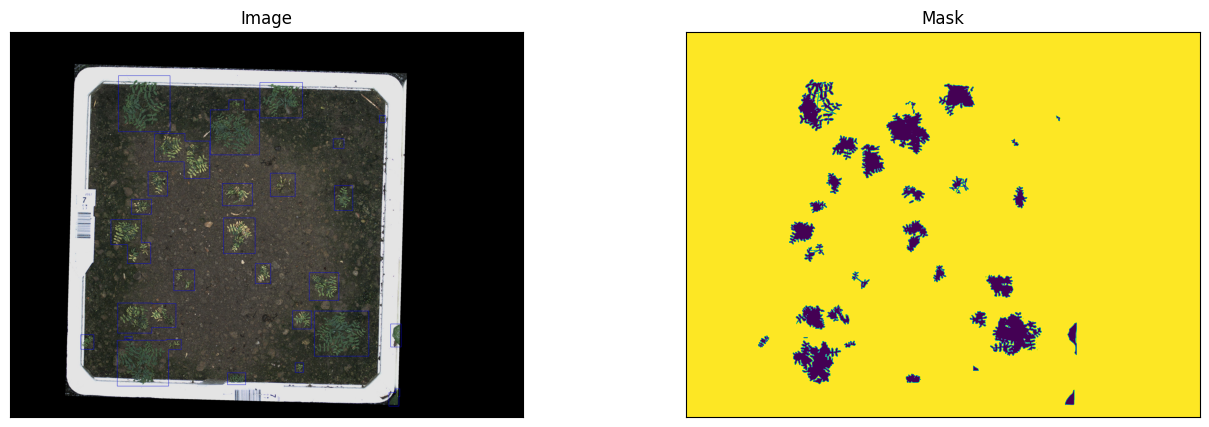

In [8]:
dataset = Dataset(x_train_dir, y_train_dir, classes=['plant'])

image, mask = dataset[5] # get some sample
visualize(
    image=image, 
    mask=mask[..., 0].squeeze(),
)

##Augmentations

In [9]:
import albumentations as A

In [10]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=h, min_width=w, always_apply=True, border_mode=0),
        # # A.RandomCrop(height=h, width=w, always_apply=True),
        A.CropNonEmptyMaskIfExists(height=h, width=w, always_apply=True,p = 1.0),

        A.GaussNoise (p=0.2),
        A.Perspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.Sharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomBrightnessContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        # A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(h, w)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

/usr/local/lib/python3.9/dist-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


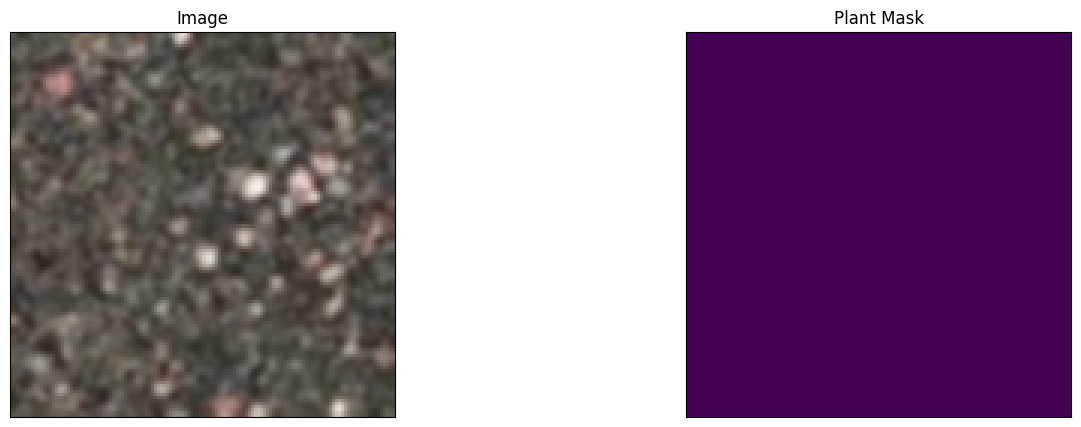

In [11]:
dataset = Dataset(x_train_dir, y_train_dir, classes=['plant'], augmentation=get_training_augmentation())

image, mask = dataset[12] # get some sample
visualize(
    image=image, 
    plant_mask=mask[..., 0].squeeze(),
    # sky_mask=mask[..., 1].squeeze(),
    # background_mask=mask[..., 2].squeeze(),
)

##Segmentation model training

In [12]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [21]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 8
CLASSES = ['plant']
LR = 0.0001
EPOCHS = 40

preprocess_input = sm.get_preprocessing(BACKBONE)

In [14]:
preprocess_input

<function efficientnet.model.preprocess_input(x, **kwargs)>

In [22]:
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

In [23]:
# define optomizer
optim = tf.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [17]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloader(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, h, w, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, h, w, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    # keras.callbacks.ModelCheckpoint('./model_v5_1024.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ModelCheckpoint('./model_v1_128_efficientnetb3.h5', save_weights_only=False, save_best_only=True, mode='max',monitor='val_iou_score'),
    # keras.callbacks.ModelCheckpoint('./model_v7_128.h5', save_weights_only=False, save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(),
]

(128, 128, 3)
2.4308496 -2.0322802


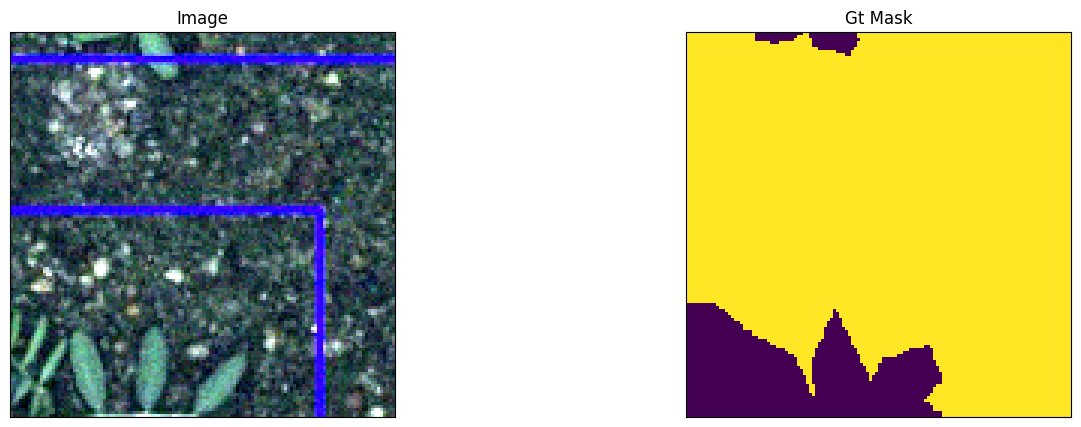

(128, 128, 3)
-0.47759098 -2.117904


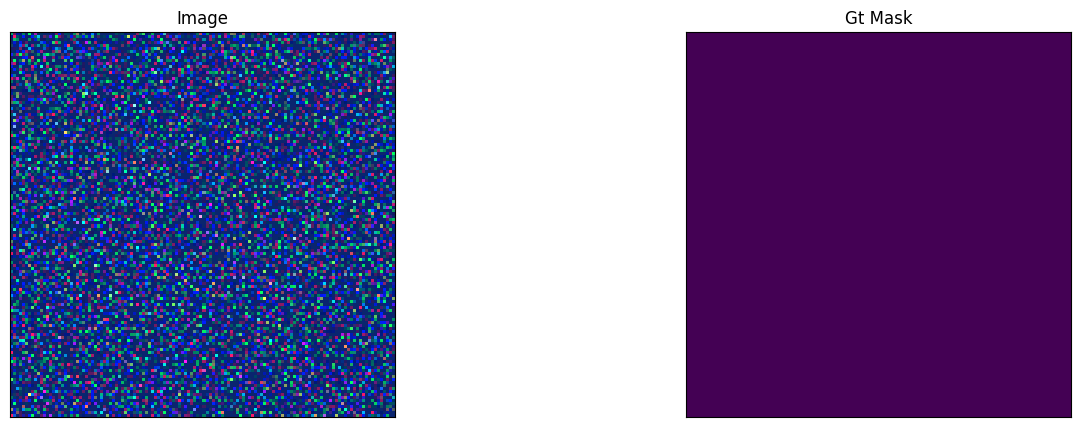

(128, 128, 3)
2.4285715 -1.2959158


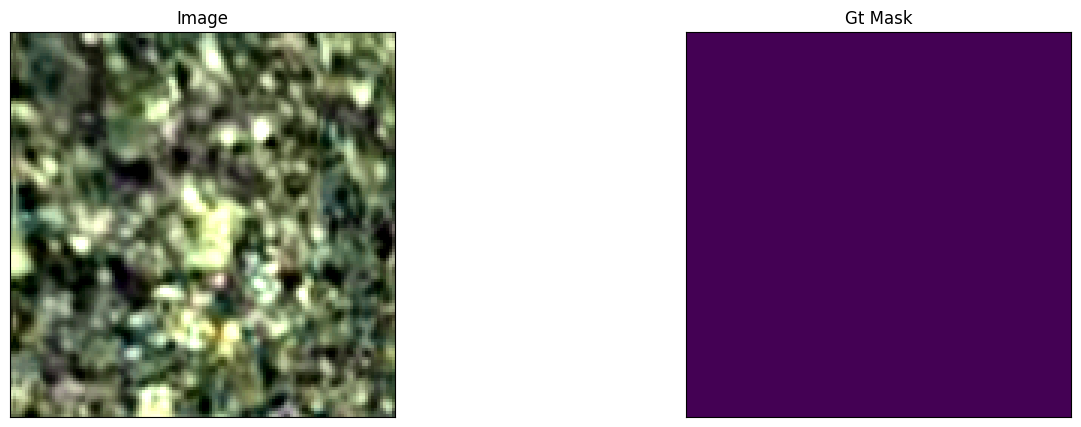

(128, 128, 3)
2.6051416 -1.7069099


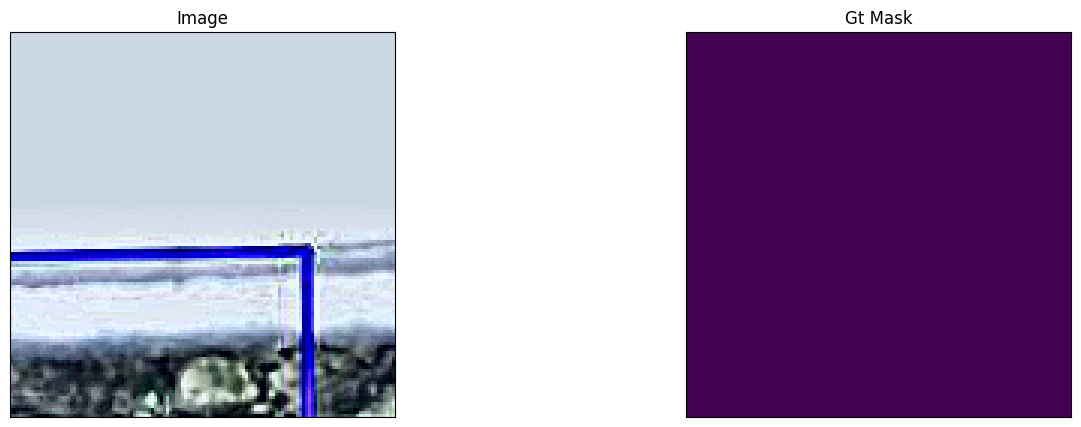

(128, 128, 3)
2.169412 -1.6555357


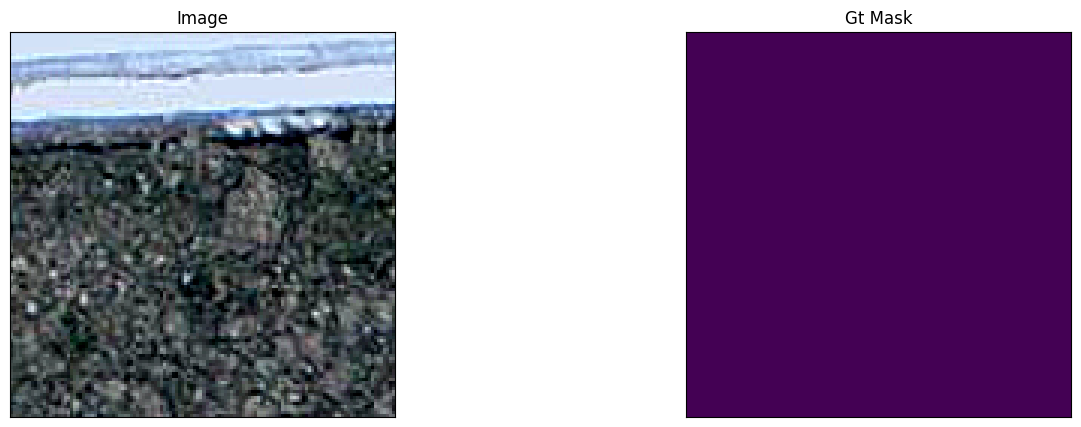

(128, 128, 3)
0.87044823 -1.7240347


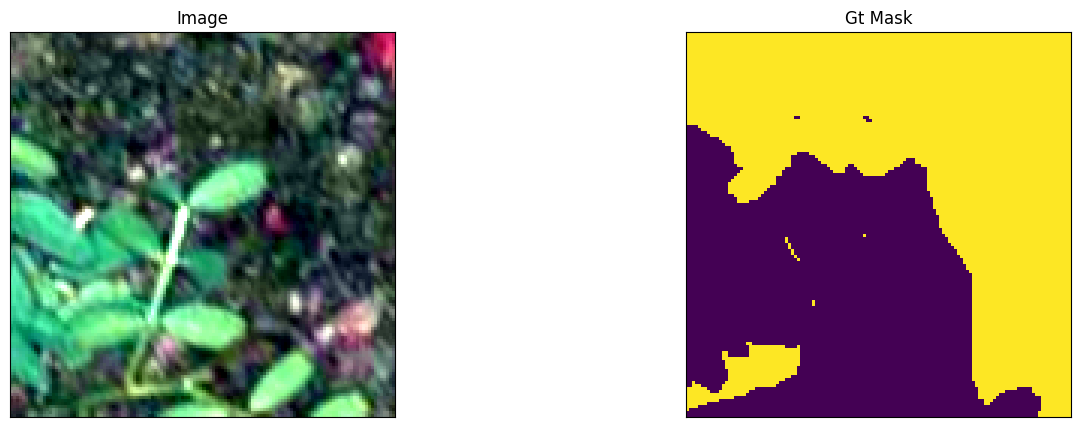

(128, 128, 3)
2.2739873 -1.6555357


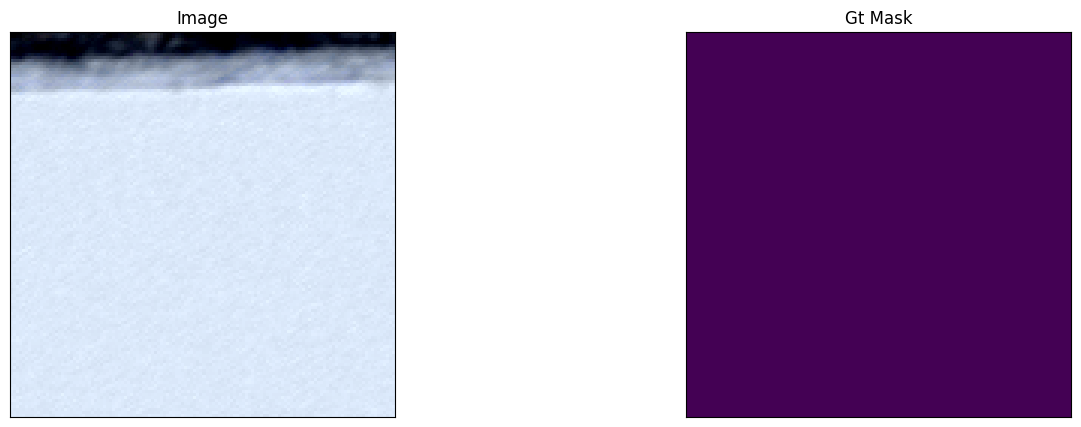

(128, 128, 3)
2.64 -2.117904


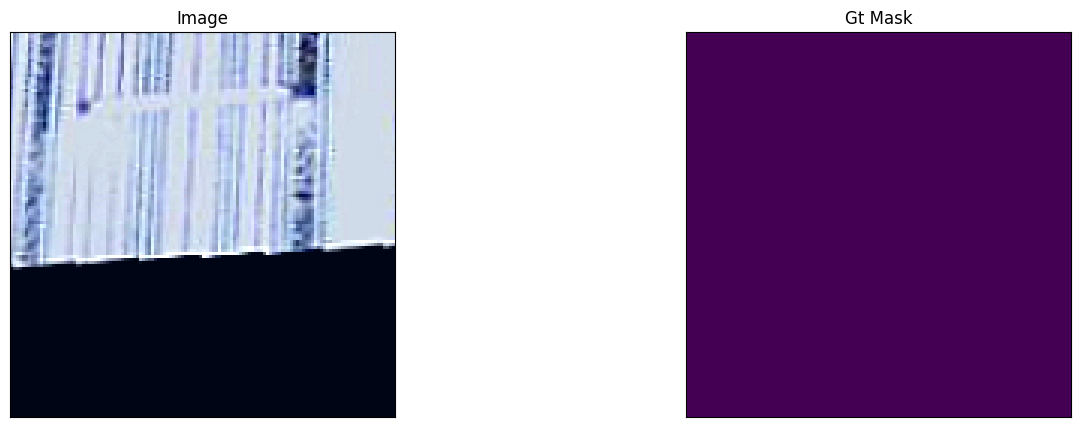

(128, 128, 3)
-1.8044444 -2.117904


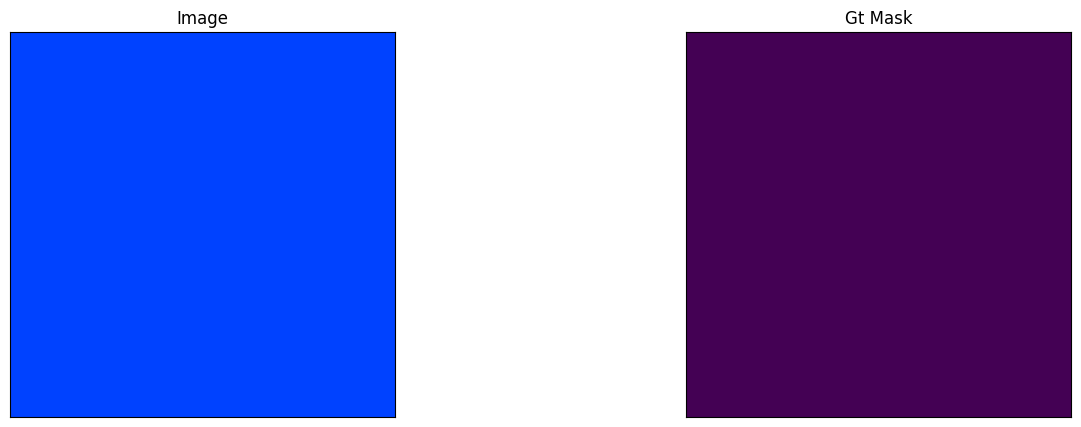

(128, 128, 3)
1.5981677 -1.230392


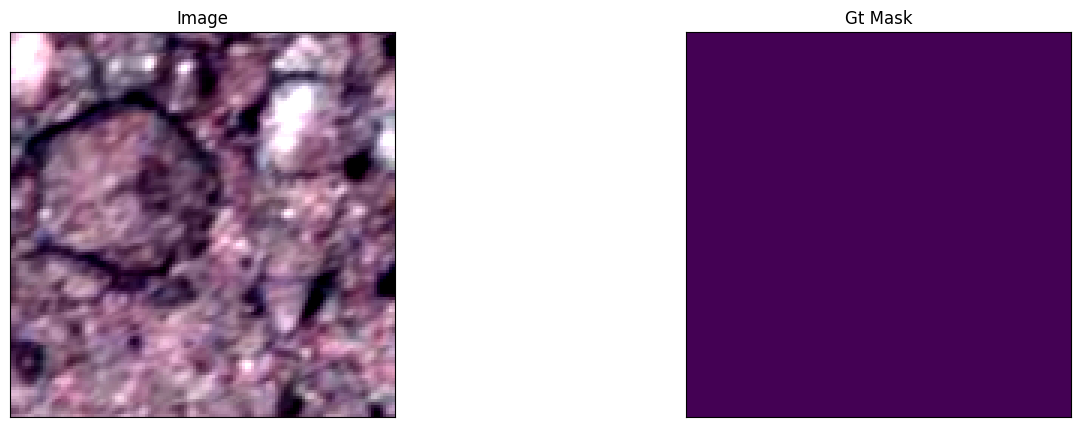

In [20]:
for i in range(10):
    
    image, gt_mask = train_dataset[i]
    print(image.shape)
    print(np.max(image),np.min(image))
    image = np.expand_dims(image, axis=0)
  
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
    )

In [24]:
# train model
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/40
12/12 [==============================] - 169s 13s/step - loss: 0.3212 - iou_score: 0.7613 - f1-score: 0.8638 - val_loss: 0.5002 - val_iou_score: 0.3606 - val_f1-score: 0.5294 - lr: 1.0000e-04
Epoch 2/40
12/12 [==============================] - 134s 11s/step - loss: 0.3031 - iou_score: 0.7879 - f1-score: 0.8805 - val_loss: 0.5260 - val_iou_score: 0.3455 - val_f1-score: 0.5129 - lr: 1.0000e-04
Epoch 3/40
12/12 [==============================] - 135s 12s/step - loss: 0.2862 - iou_score: 0.8155 - f1-score: 0.8978 - val_loss: 0.4788 - val_iou_score: 0.3544 - val_f1-score: 0.5224 - lr: 1.0000e-04
Epoch 4/40
12/12 [==============================] - 137s 12s/step - loss: 0.2666 - iou_score: 0.8610 - f1-score: 0.9245 - val_loss: 0.4021 - val_iou_score: 0.4147 - val_f1-score: 0.5851 - lr: 1.0000e-04
Epoch 5/40
12/12 [==============================] - 137s 12s/step - loss: 0.2441 - iou_score: 0.8826 - f1-score: 0.9375 - val_loss: 0.2675 - val_iou_score: 0.4876 - val_f1-score: 0.6548 - 

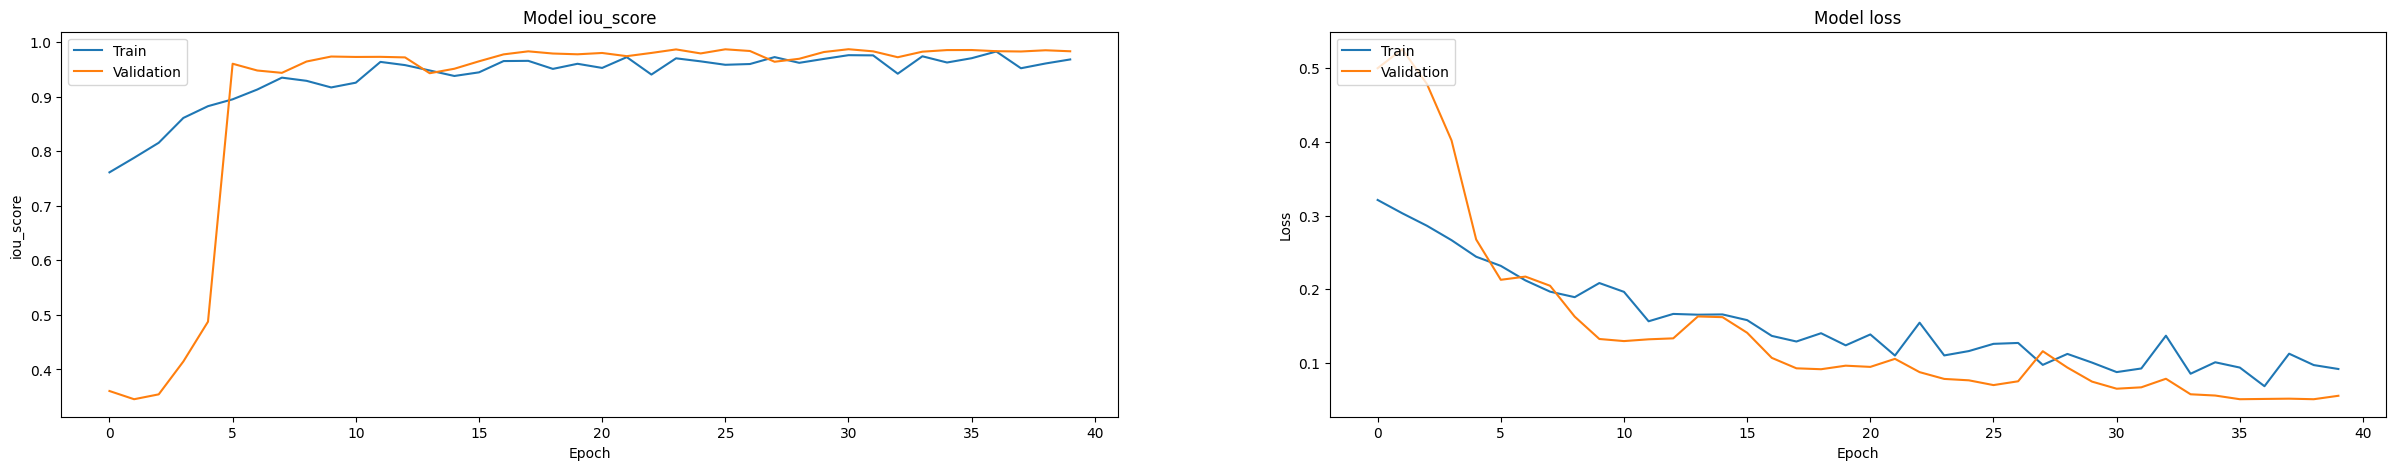

In [25]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

##Model Evaluation

In [26]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloader(test_dataset, batch_size=1, shuffle=False)

In [27]:
scores = model.evaluate(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

16/16 [==============================] - 23s 1s/step - loss: 0.0499 - iou_score: 0.9886 - f1-score: 0.9942
Loss: 0.04992
mean iou_score: 0.98859
mean f1-score: 0.99424


In [ ]:
model.save('/content/drive/MyDrive/Project/model_v1_128_efficientnetb3.h5')

##Visualization of results on test dataset

1/1 [==============================] - 0s 189ms/step
(1, 3072, 4096, 1)


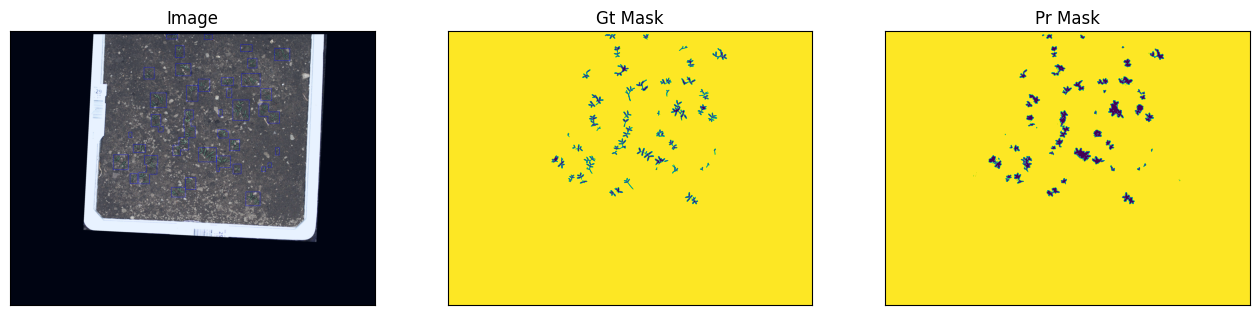

1/1 [==============================] - 0s 183ms/step
(1, 3072, 4096, 1)


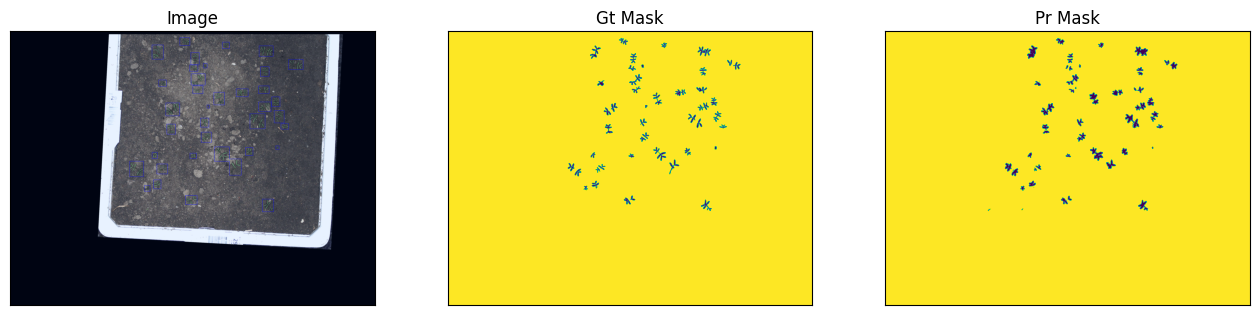

1/1 [==============================] - 0s 186ms/step
(1, 3072, 4096, 1)


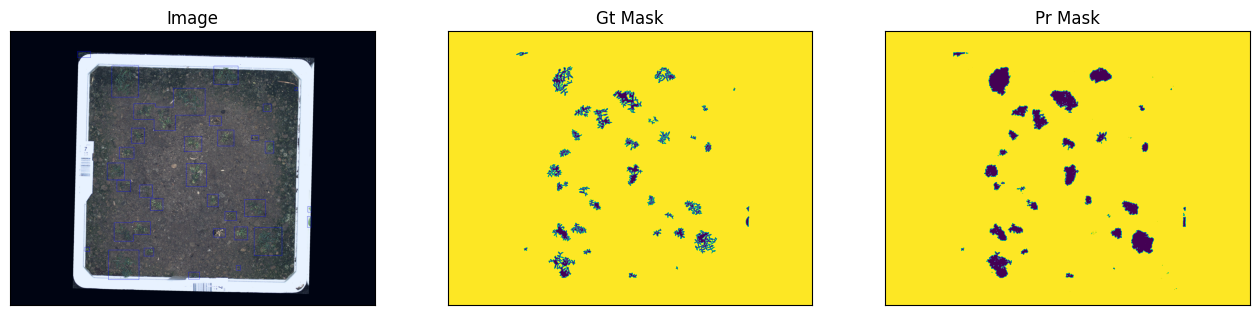

1/1 [==============================] - 0s 184ms/step
(1, 3072, 4096, 1)


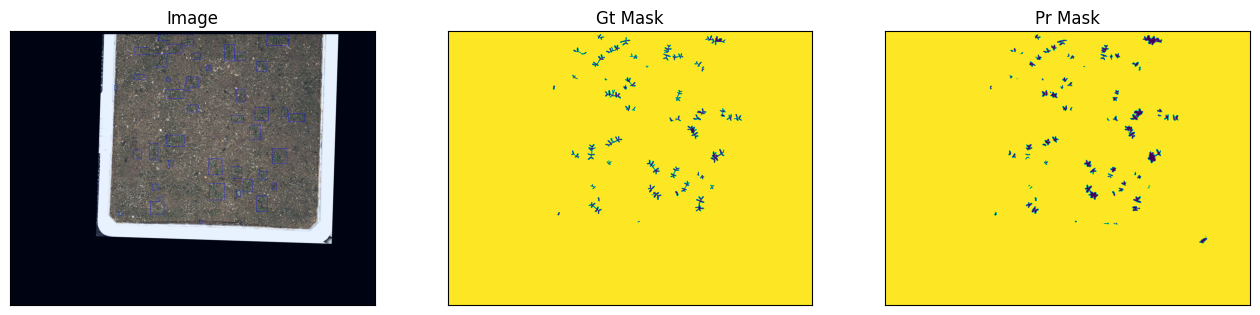

1/1 [==============================] - 0s 193ms/step
(1, 3072, 4096, 1)


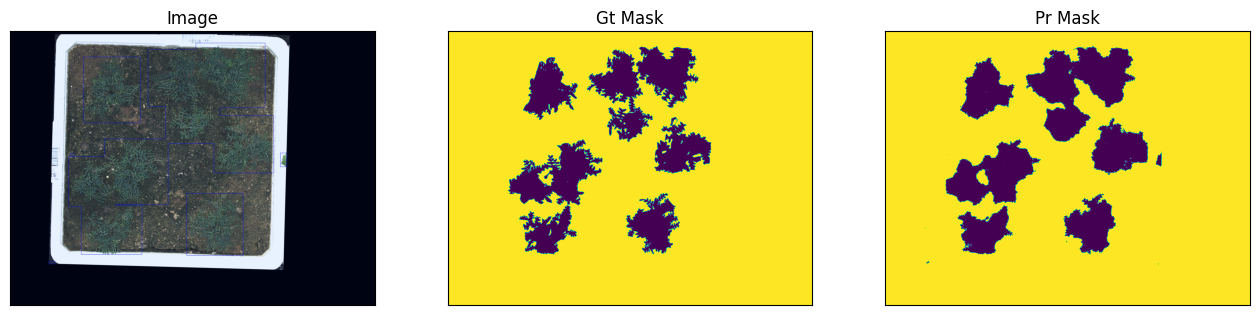

1/1 [==============================] - 0s 180ms/step
(1, 3072, 4096, 1)


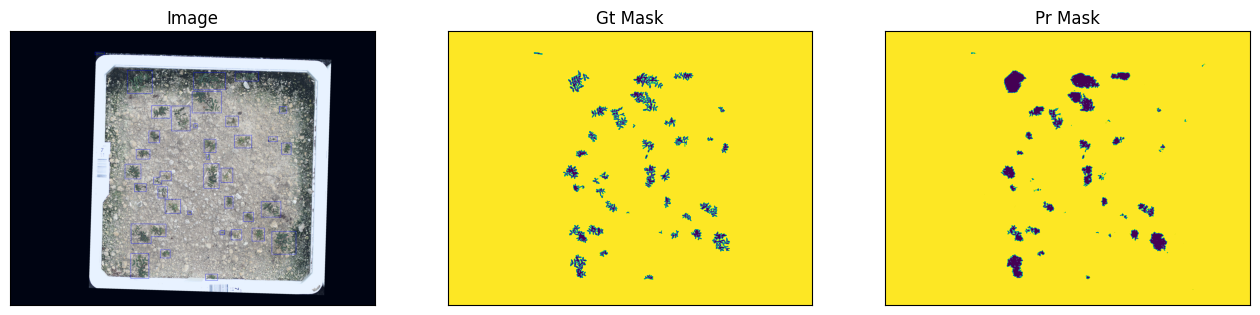

1/1 [==============================] - 0s 184ms/step
(1, 3072, 4096, 1)


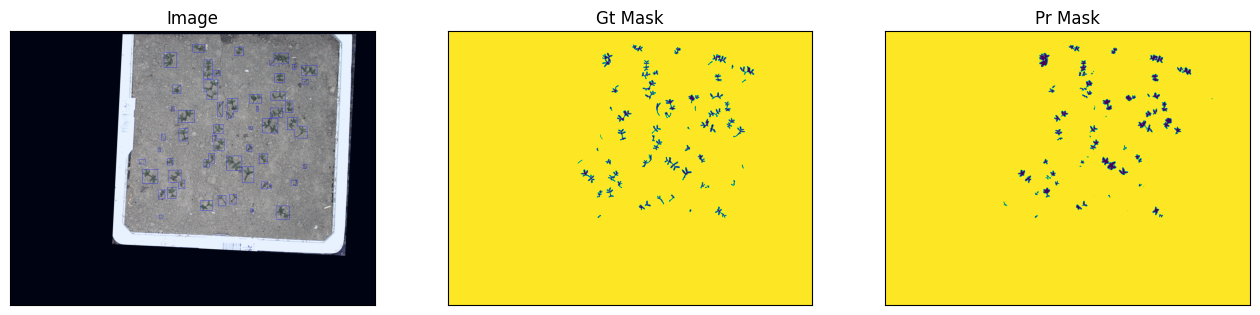

1/1 [==============================] - 0s 186ms/step
(1, 3072, 4096, 1)


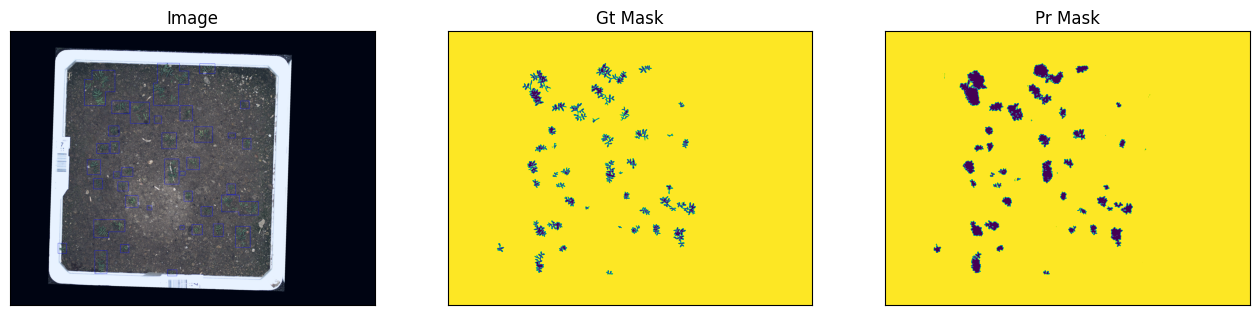

1/1 [==============================] - 0s 170ms/step
(1, 3072, 4096, 1)


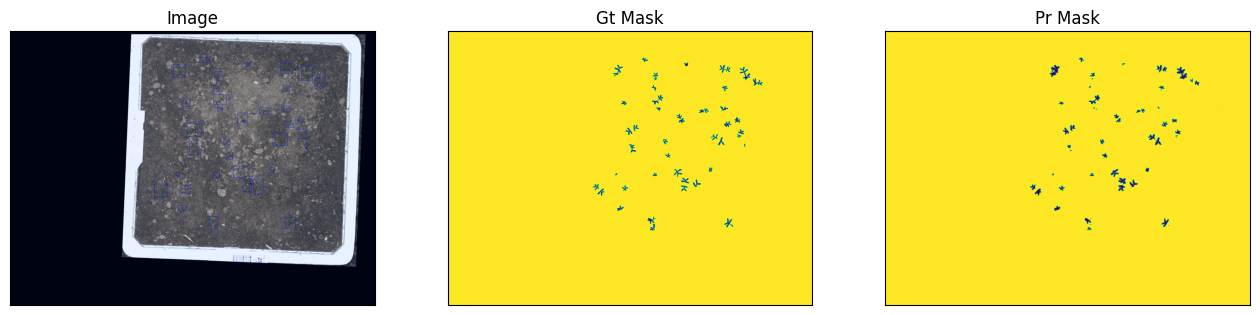

1/1 [==============================] - 0s 172ms/step
(1, 3072, 4096, 1)


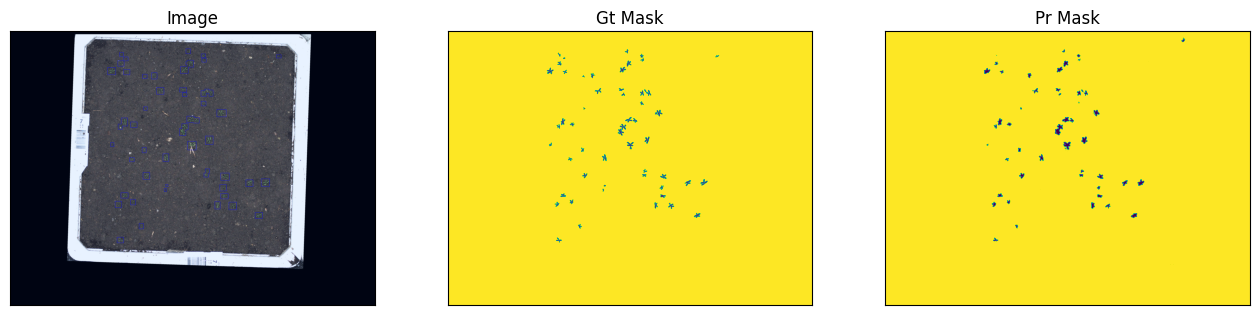

1/1 [==============================] - 0s 172ms/step
(1, 3072, 4096, 1)


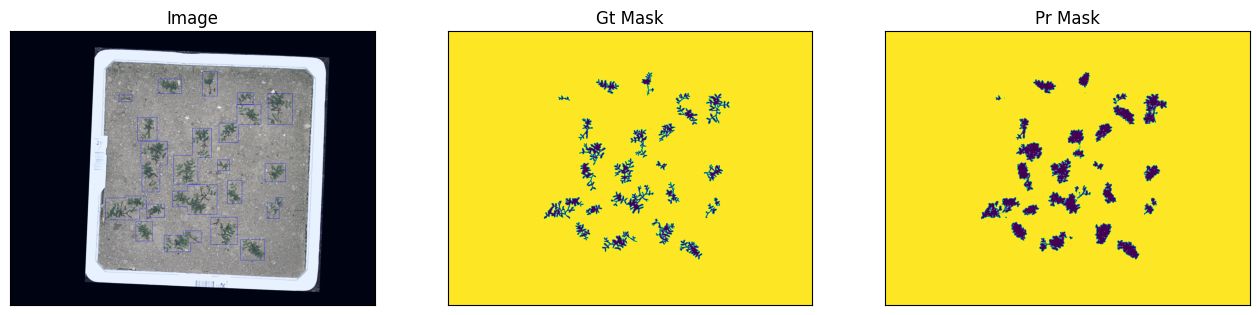

1/1 [==============================] - 0s 174ms/step
(1, 3072, 4096, 1)


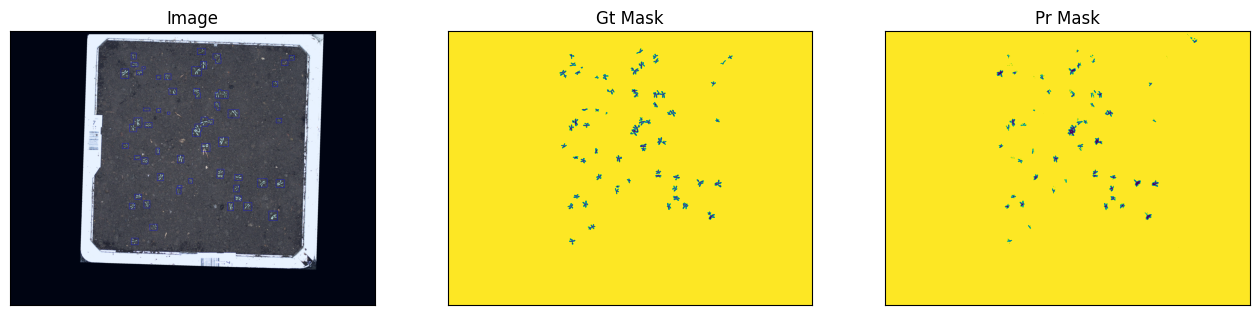

1/1 [==============================] - 0s 174ms/step
(1, 3072, 4096, 1)


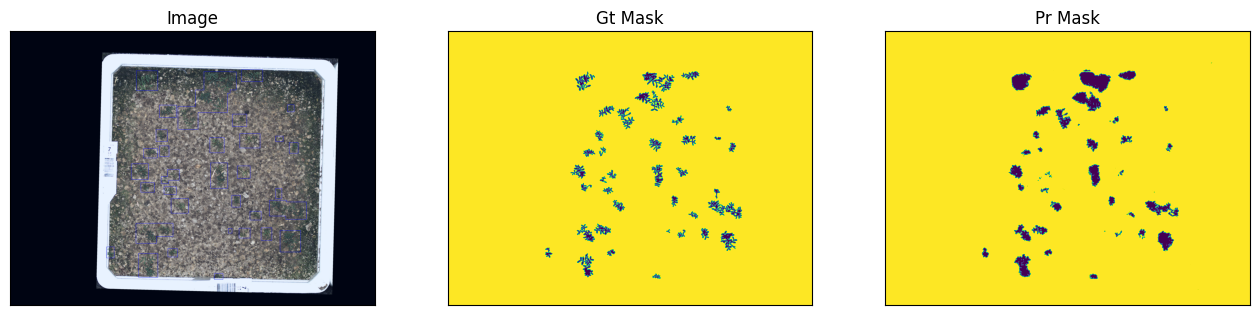

1/1 [==============================] - 0s 171ms/step
(1, 3072, 4096, 1)


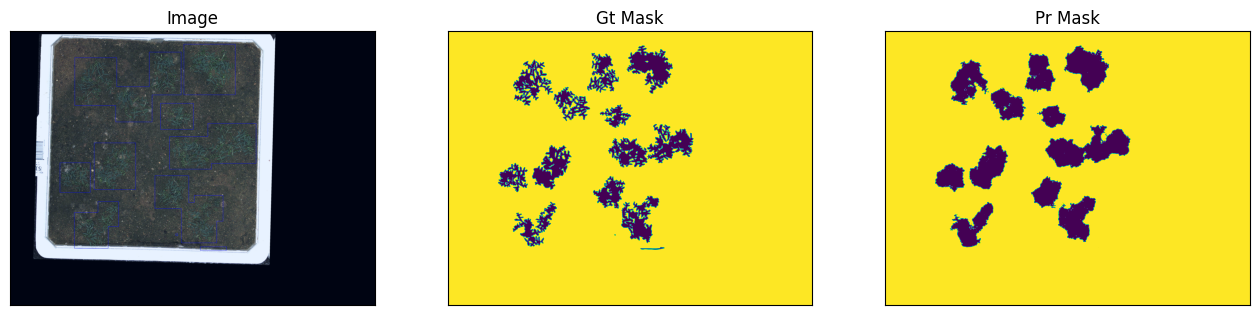

1/1 [==============================] - 0s 172ms/step
(1, 3072, 4096, 1)


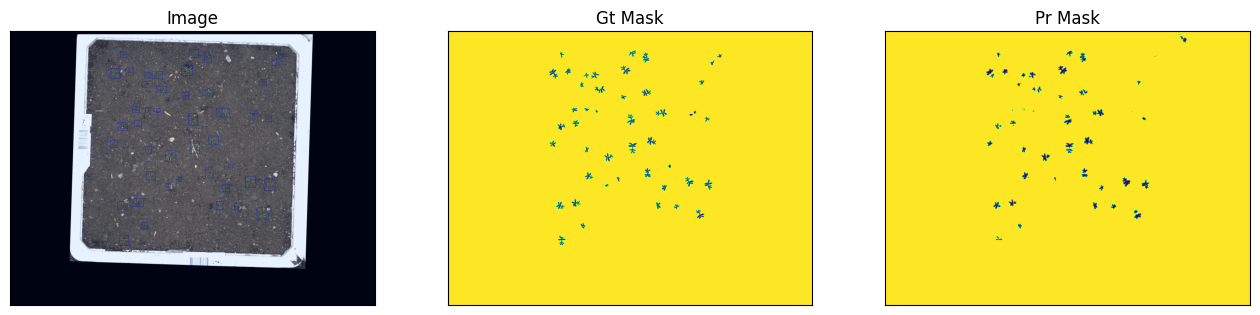

In [29]:
from PIL import Image

n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
for i in range(len(test_dataset)-1):
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    # print(pr_mask.shape)
    # pr_mask = cv2.morphologyEx(pr_mask[..., 0].squeeze(), cv2.MORPH_OPEN, kernel)
    print(pr_mask.shape)
    # im = Image.fromarray(pr_mask)
    # im.save(f'{i}.png')
 
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )